In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.io import fits
import healpy as hp

In [16]:
def raDec2Hpid(nside, ra, dec):
    """
    Assign ra,dec points to the correct healpixel.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    ra : np.array
        RA values to assign to healpixels.
    dec : np.array
        Dec values to assign to healpixels.

    Returns
    -------
    hpids : np.array
        Healpixel IDs for the input positions.
    """
    lat = np.pi/2. - dec
    hpids = hp.ang2pix(nside, lat, ra)
    return hpids


def healbin(ra, dec, values, nside=128, reduceFunc=np.mean, dtype=float):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points.
    dec : np.array
        Dec positions of the data points.
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduceFunc : function (numpy.mean)
        A function that will return a single value given a subset of `values`.

    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.
    """

    hpids = raDec2Hpid(nside, ra, dec)

    order = np.argsort(hpids)
    hpids = hpids[order]
    values = values[order]
    pixids = np.unique(hpids)
    pixids = np.arange(hp.nside2npix(nside))

    left = np.searchsorted(hpids, pixids)
    right = np.searchsorted(hpids, pixids, side='right')

    mapVals = np.zeros(hp.nside2npix(nside), dtype=dtype)+hp.UNSEEN

    # Wow, I thought histogram would be faster than the loop, but this has been faster!
    for i, idx in enumerate(pixids):
        mapVals[idx] = reduceFunc(values[left[idx]:right[idx]] )

    # Change any NaNs to healpy mask value
    mapVals[np.isnan(mapVals)] = hp.UNSEEN

    return mapVals


In [3]:
hdulist = fits.open('ut012716.0100.long.M.fits')

In [4]:
image = hdulist[0].data

In [5]:
image

array([[2038, 2036, 2051, ..., 2040, 2048, 2054],
       [2059, 2055, 2040, ..., 2054, 2054, 2048],
       [2036, 2049, 2042, ..., 2041, 2056, 2054],
       ..., 
       [2041, 2044, 2051, ..., 2049, 2048, 2050],
       [2044, 2043, 2041, ..., 2052, 2045, 2051],
       [2041, 2041, 2042, ..., 2037, 2046, 2071]], dtype=int16)

In [6]:
coords = np.genfromtxt('ut012716.0100.long.M.xxyy', dtype=[int,int,float,float])

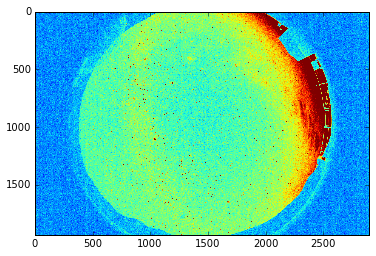

In [7]:
plt.imshow(image, vmin=image.min(), vmax=image.min()+100)
#plt.figure()
#ax = plt.subplot(111, projection = 'mollweide')
#ax.plot(coords[:,2],coords[:,3])

In [8]:
print image.shape, coords.shape


(1935, 2897) (5600864,)


In [17]:
healMap = healbin(np.radians(coords['f2']), np.radians(coords['f3']), 
                  image[coords['f1'],coords['f0'] ], reduceFunc=np.median )

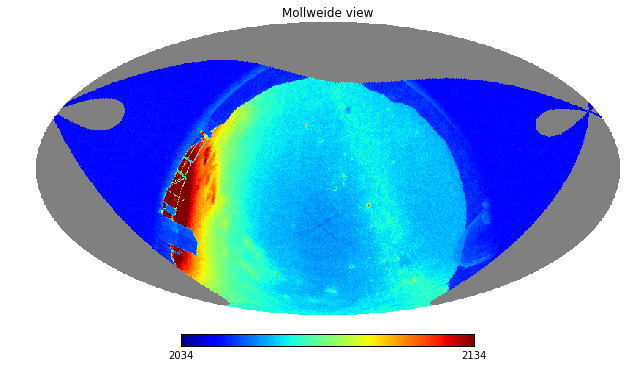

In [18]:
hp.mollview(healMap, max=2134)

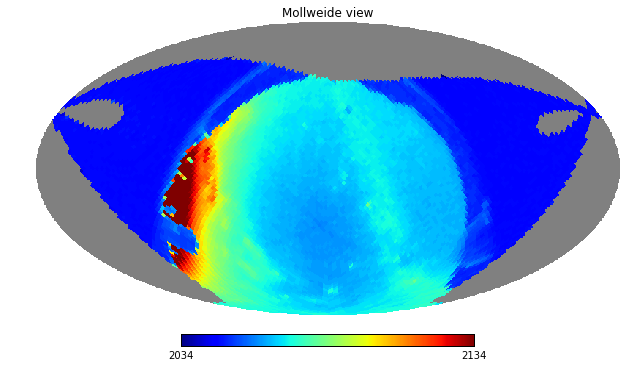

In [19]:
healMap = healbin(np.radians(coords['f2']), np.radians(coords['f3']), 
                  image[coords['f1'],coords['f0'] ],nside=32, reduceFunc=np.median  )
hp.mollview(healMap, max=2134)

In [ ]:
help(healbin)